# RAMP on predicting cyclist traffic in Paris


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Loading the data with pandas

First, download the data files from Kaggle, and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [3]:
print(min(data["date"]), max(data["date"]))

2020-09-01 01:00:00 2021-09-09 23:00:00


In [4]:
print(min(data["counter_installation_date"]), max(data["counter_installation_date"]))

2013-01-18 00:00:00 2020-11-29 00:00:00


We can check general information about different columns:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

and in particular the number of unique entries in each column,

In [6]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location. Let's see if two counters at the same place notice the same amount of people:

In [7]:
(
    data.groupby(["site_name"])["counter_name"].nunique()
    .sort_values(ascending=False)
    .head(5)
    .to_frame()
)

C:\Users\willi\AppData\Local\Temp\ipykernel_19504\1952326111.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name"])["counter_name"].nunique()


,counter_name
site_name,
152 boulevard du Montparnasse,2
Face au 4 avenue de la porte de Bagnolet,2
Totem Cours la Reine,2
Totem 85 quai d'Austerlitz,2
Totem 73 boulevard de Sébastopol,2


<Axes: xlabel='date'>

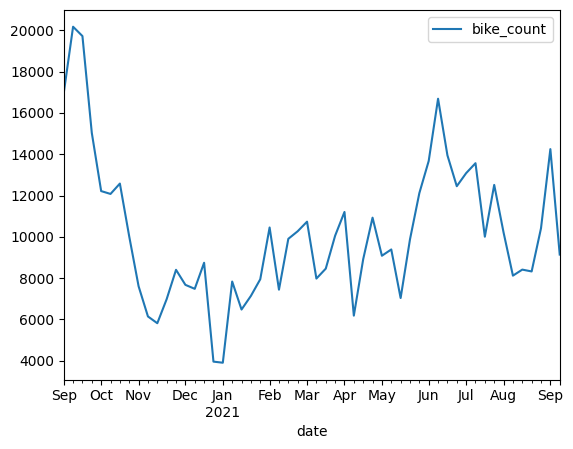

In [8]:
mask_1 = data["site_name"] == "18 quai de l'Hôtel de Ville"
data[mask_1].groupby(
    pd.Grouper(freq="1W", key="date")
)[["bike_count"]].sum().plot()

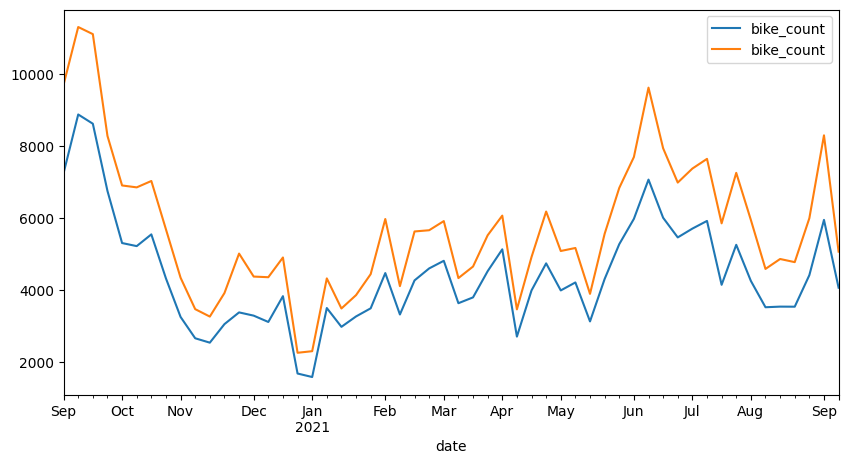

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

for column in data[mask_1]["counter_name"].unique():
    (data[data["counter_name"] == column]).groupby(
        pd.Grouper(freq="1W", key="date")
    )[["bike_count"]].sum().plot(ax=ax, label=column)

Let's look at the most frequented stations:

In [10]:
(
    data.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(5)
    .to_frame()
)

C:\Users\willi\AppData\Local\Temp\ipykernel_19504\1821865552.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name", "counter_name"])["bike_count"].sum()


,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1992227.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1551730.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1497912.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1130565.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1015875.0


In [11]:
(
    data.groupby(["site_name"])["counter_name"].count()
    .head(5)
    .to_frame()
)

C:\Users\willi\AppData\Local\Temp\ipykernel_19504\1949684205.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name"])["counter_name"].count()


,counter_name
site_name,
152 boulevard du Montparnasse,17936
18 quai de l'Hôtel de Ville,17948
20 Avenue de Clichy,17948
254 rue de Vaugirard,13154
27 quai de la Tournelle,17948


# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [12]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=12)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

c:\Users\willi\anaconda3\Lib\site-packages\folium\utilities.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = (location[0], location[1])


Note that in this challenge, we consider only the 30 most frequented counting sites, to limit data size.

Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points:

<Axes: xlabel='date', ylabel='bike_count'>

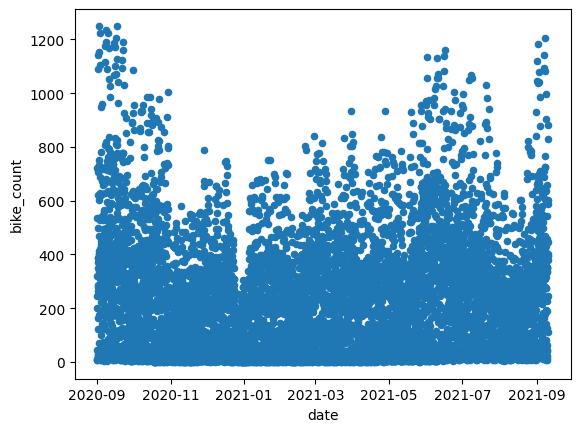

In [13]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot.scatter(x="date", y="bike_count")

Instead we aggregate the data, for instance, by week to have a clearer overall picture:

<Axes: xlabel='date'>

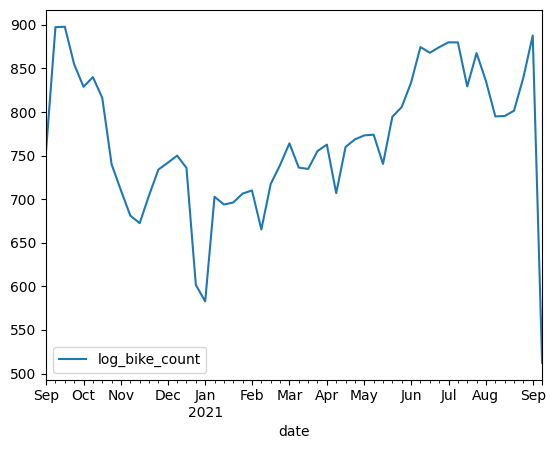

In [14]:
mask = (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")

data[mask].groupby(
    pd.Grouper(freq="1W", key="date")
)[["log_bike_count"]].sum().plot()

While at the same time, we can zoom on a week in particular for a more short-term visualization,

<Axes: xlabel='date'>

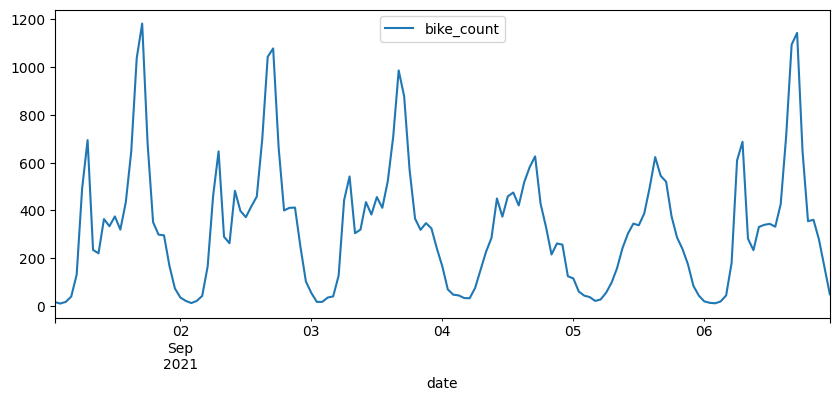

In [34]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/09/01"))
    & (data["date"] < pd.to_datetime("2021/09/07"))
)

data[mask].sort_values(by="date").plot(x="date", y="bike_count", ax=ax)

<Axes: xlabel='date'>

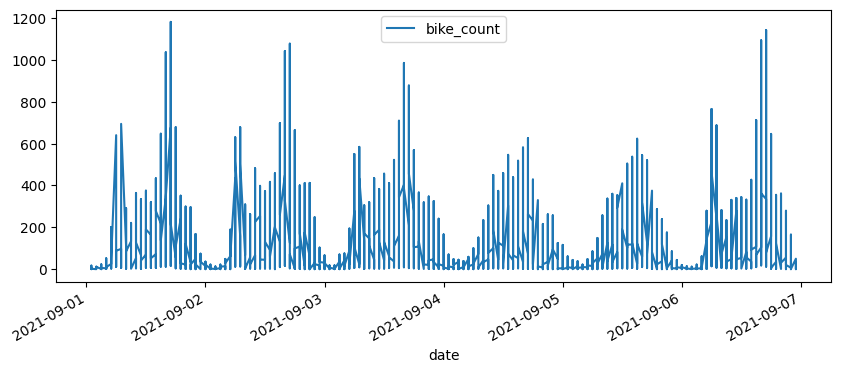

In [32]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = ((data["date"] > pd.to_datetime("2021/09/01")) & (data["date"] < pd.to_datetime("2021/09/07")))

data[mask].sort_values(by="date").plot(x="date", y="bike_count", ax=ax)

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

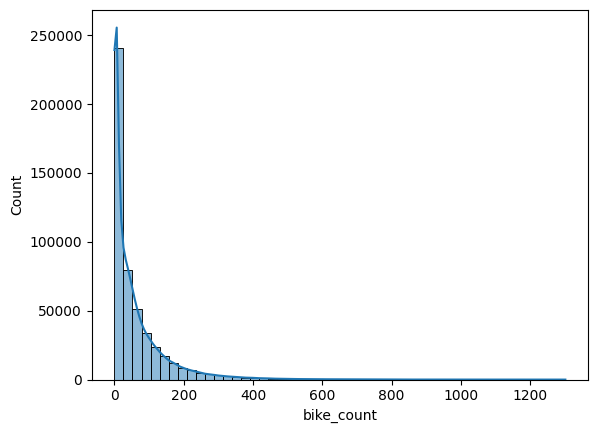

In [16]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

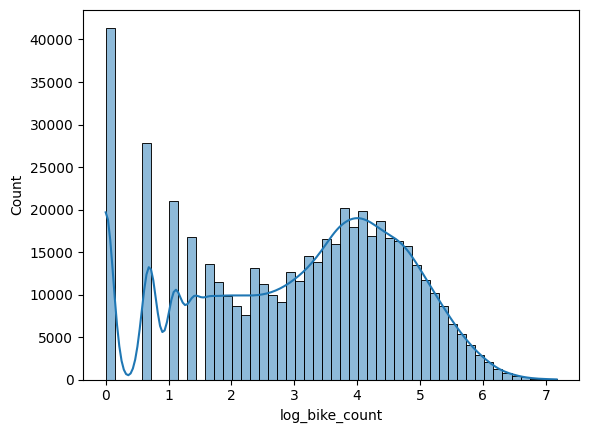

In [17]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field:

In [ ]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [19]:
data["date"].head()

48321   2020-09-01 02:00:00
48324   2020-09-01 03:00:00
48327   2020-09-01 04:00:00
48330   2020-09-01 15:00:00
48333   2020-09-01 18:00:00
Name: date, dtype: datetime64[us]

In [20]:
_encode_dates(data[["date"]].head())

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html):

In [21]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
sample_encoded = date_encoder.fit_transform(data[["date"]]).head()
sample_encoded

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [22]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(sample_encoded[["hour"]])

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

## Linear model

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `utils.py` of the starting kit to load the train set.

In [23]:
import utils

X, y = utils.get_train_data()
X.head(2)

,date,counter_name
400125,2020-09-01 01:00:00,152 boulevard du Montparnasse E-O
408305,2020-09-01 01:00:00,152 boulevard du Montparnasse O-E


and

In [24]:
y

array([1.60943791, 1.38629436, 0.        , ..., 3.49650756, 2.30258509,
       2.07944154])

Where `y` contains the `log_bike_count` variable. 

To test our baseline estimator, we create a validations set from the training set. Note that, during modeling and exploring the data, we always recommend using cross validation rather than a single train / validation split to evaluate your first results, because this will bring more stability and generalization.

We create the validation set by simply slicing the last 30 days of the training set:

In [25]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [26]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=456507,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=40320,  2021-08-11 00:00:00 to 2021-09-09 23:00:00


In [27]:
_encode_dates(X_train[["date"]]).columns.tolist()

['year', 'month', 'day', 'weekday', 'hour']

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

ValueError: A given column is not a column of the dataframe

We then evaluate this model with the RMSE metric,

In [ ]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

Train set, RMSE=0.80
Valid set, RMSE=0.73


C:\Users\willi\OneDrive\Bureau\X-HEC\Python projects\Kaggle_challenge\bike_counters\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\willi\OneDrive\Bureau\X-HEC\Python projects\Kaggle_challenge\bike_counters\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [ ]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44


C:\Users\willi\OneDrive\Bureau\X-HEC\Python projects\Kaggle_challenge\bike_counters\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\willi\OneDrive\Bureau\X-HEC\Python projects\Kaggle_challenge\bike_counters\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations (we transform the logarithmic bike counts back to their original unit):

In [ ]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/03"))
    & (X_valid["date"] < pd.to_datetime("2021/09/05"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

NameError: name 'X_valid' is not defined

Text(0, 0.5, 'bike_count')

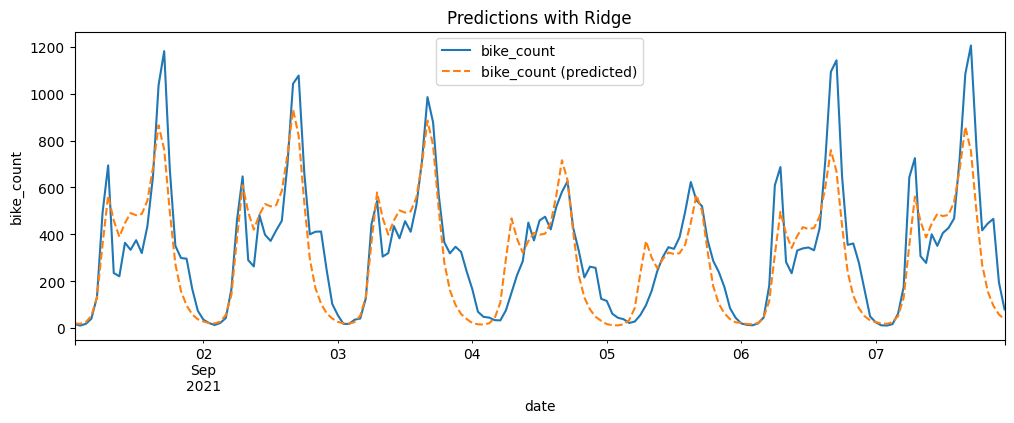

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

<Axes: xlabel='y_true', ylabel='y_pred'>

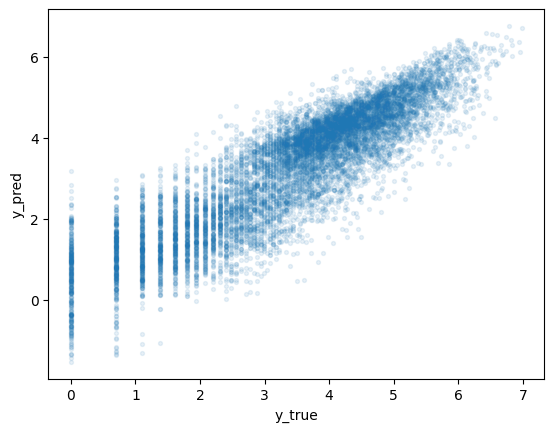

In [33]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_valid, "y_pred": pipe.predict(X_valid)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores:

In [34]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.96370992 -0.87155645 -0.85104484 -0.87402962 -1.06387373 -0.96757066]
RMSE (all folds): 0.932 ± 0.0744


In [35]:
ext_data = pd.read_csv("external_data/external_data.csv")

In [36]:
ext_data.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


In [37]:
test_data = pd.read_parquet(Path("data") / "final_test.parquet")

In [38]:
test_data.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429


In [42]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51440 entries, 0 to 51439
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   counter_id                 51440 non-null  category      
 1   counter_name               51440 non-null  category      
 2   site_id                    51440 non-null  int64         
 3   site_name                  51440 non-null  category      
 4   date                       51440 non-null  datetime64[us]
 5   counter_installation_date  51440 non-null  datetime64[us]
 6   coordinates                51440 non-null  category      
 7   counter_technical_id       51440 non-null  category      
 8   latitude                   51440 non-null  float64       
 9   longitude                  51440 non-null  float64       
dtypes: category(5), datetime64[us](2), float64(2), int64(1)
memory usage: 2.2 MB


In [59]:
result = pipe.predict(test_data)

output = pd.DataFrame({
    'log_bike_count': result
})

output.index.name = "Id"

output.to_csv('output.csv')

,log_bike_count
Id,
0,-0.689768
1,2.457017
2,2.904067
3,1.879698
4,0.354138
...,...
51435,4.569524
51436,4.901681
51437,5.008214


array([[<Axes: title={'center': 'site_id'}>,
        <Axes: title={'center': 'date'}>],
       [<Axes: title={'center': 'counter_installation_date'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'longitude'}>, <Axes: >]], dtype=object)

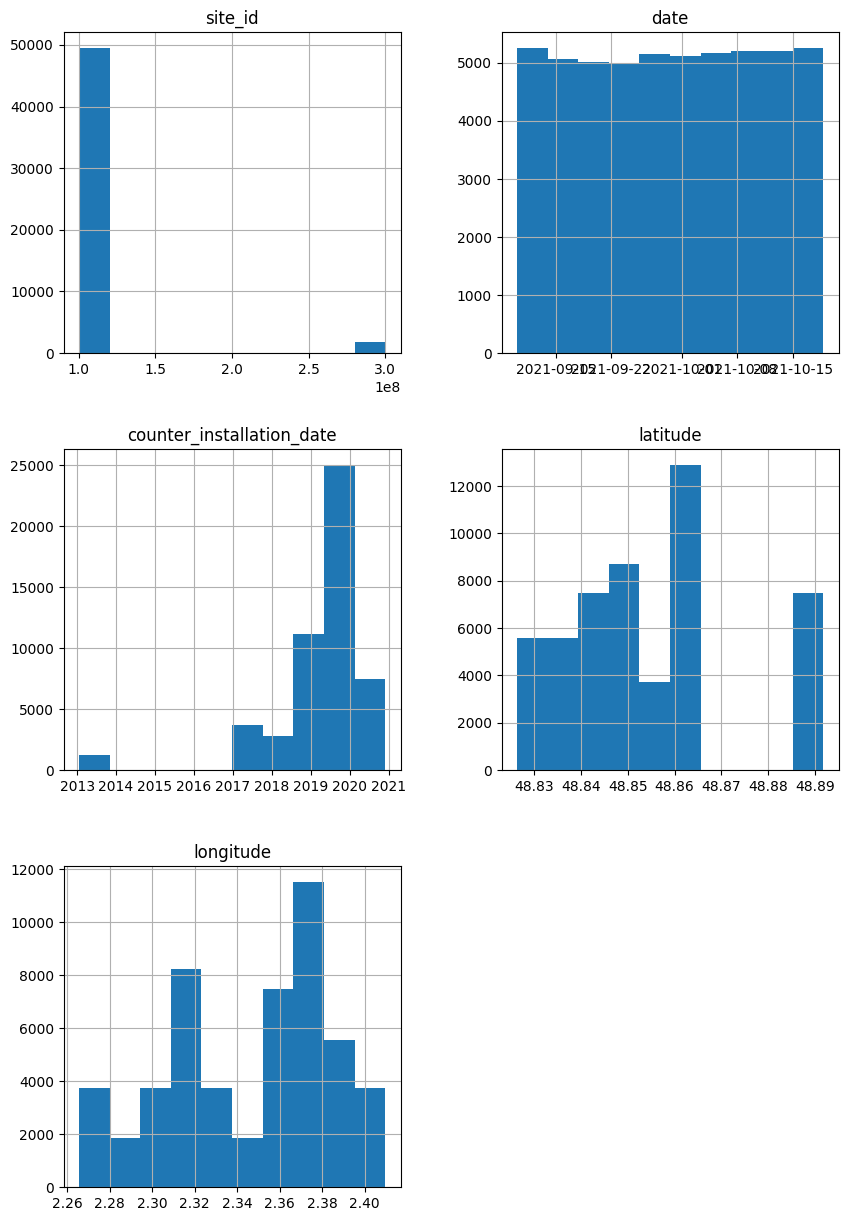

In [42]:
test_data.hist(figsize=(10,15))

array([[<Axes: title={'center': 'numer_sta'}>,
        <Axes: title={'center': 'pmer'}>,
        <Axes: title={'center': 'tend'}>,
        <Axes: title={'center': 'cod_tend'}>,
        <Axes: title={'center': 'dd'}>, <Axes: title={'center': 'ff'}>,
        <Axes: title={'center': 't'}>, <Axes: title={'center': 'td'}>],
       [<Axes: title={'center': 'u'}>, <Axes: title={'center': 'vv'}>,
        <Axes: title={'center': 'ww'}>, <Axes: title={'center': 'w1'}>,
        <Axes: title={'center': 'w2'}>, <Axes: title={'center': 'n'}>,
        <Axes: title={'center': 'nbas'}>,
        <Axes: title={'center': 'hbas'}>],
       [<Axes: title={'center': 'cl'}>, <Axes: title={'center': 'cm'}>,
        <Axes: title={'center': 'ch'}>, <Axes: title={'center': 'pres'}>,
        <Axes: title={'center': 'niv_bar'}>,
        <Axes: title={'center': 'geop'}>,
        <Axes: title={'center': 'tend24'}>,
        <Axes: title={'center': 'tn12'}>],
       [<Axes: title={'center': 'tn24'}>,
        <Axes: tit

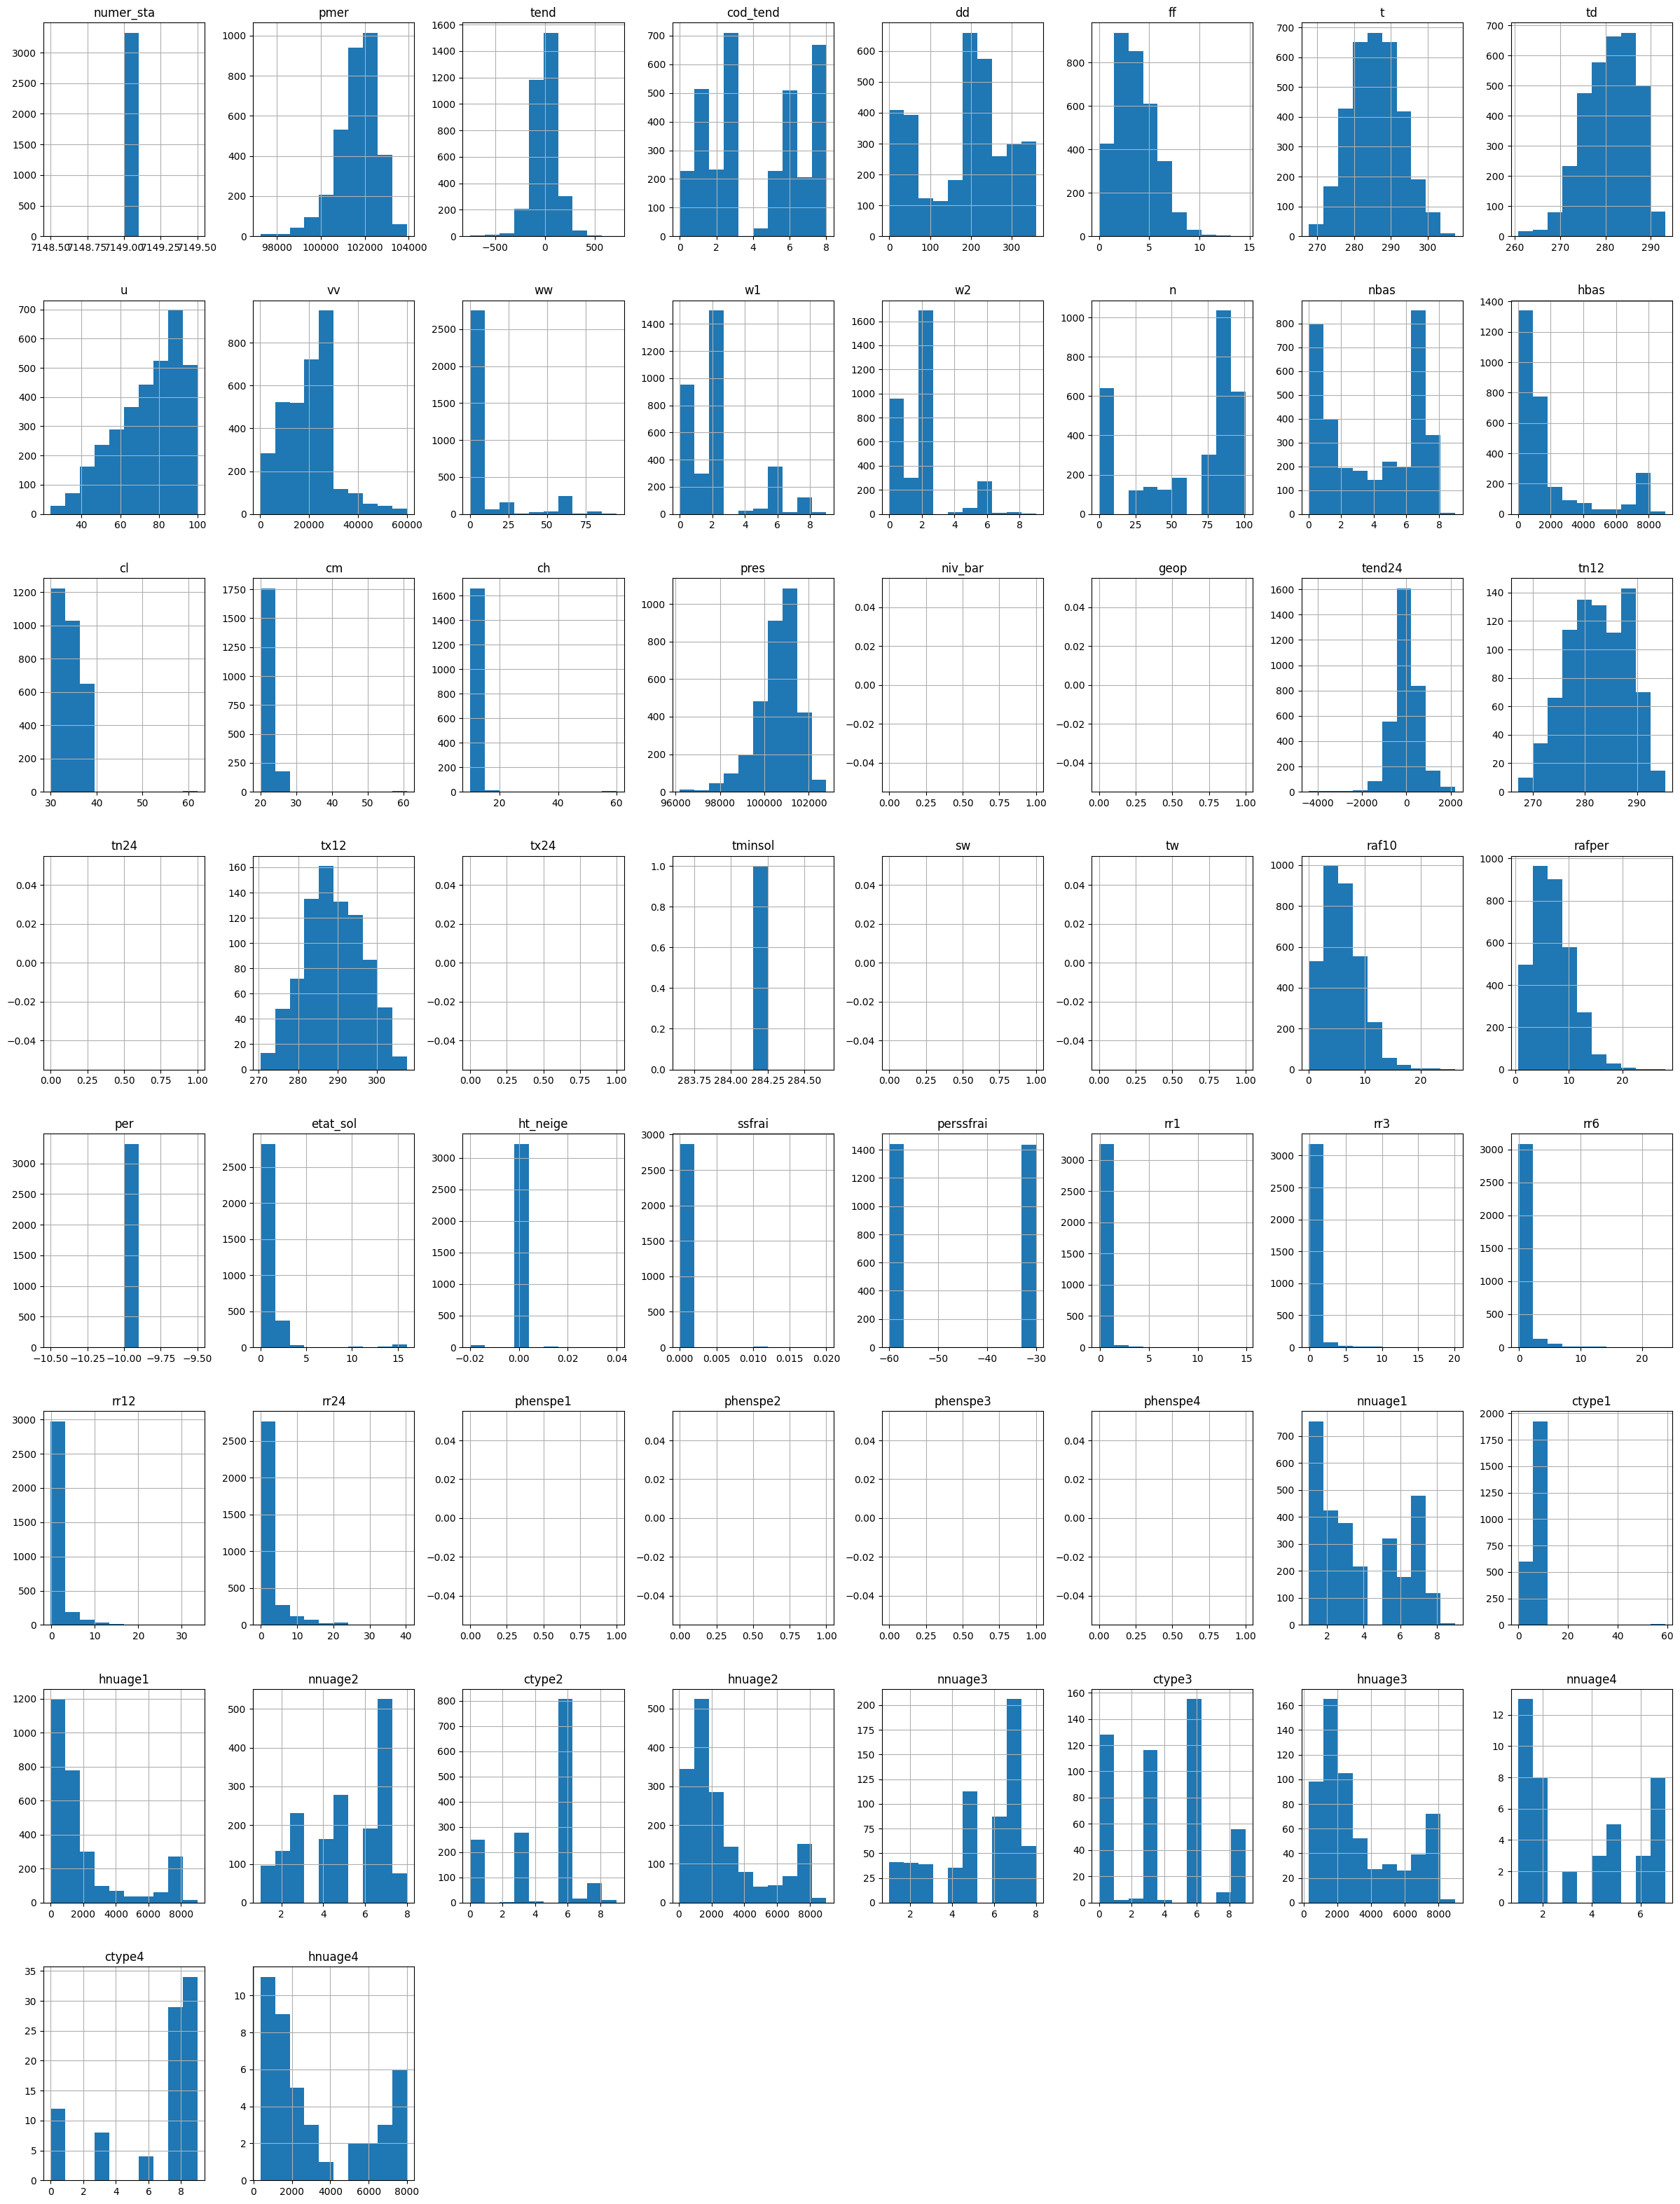

In [43]:
ext_data.hist(figsize=(30,40))

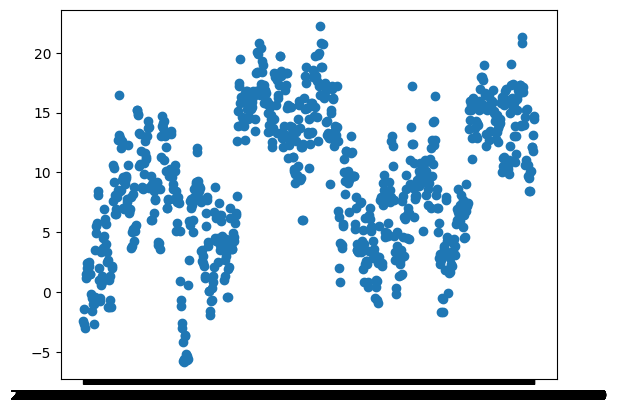

In [44]:
plt.scatter(ext_data["date"], ext_data["tn12"]-273.15)

In [45]:
ext_data["date"] = pd.to_datetime(ext_data["date"])

<Axes: xlabel='date'>

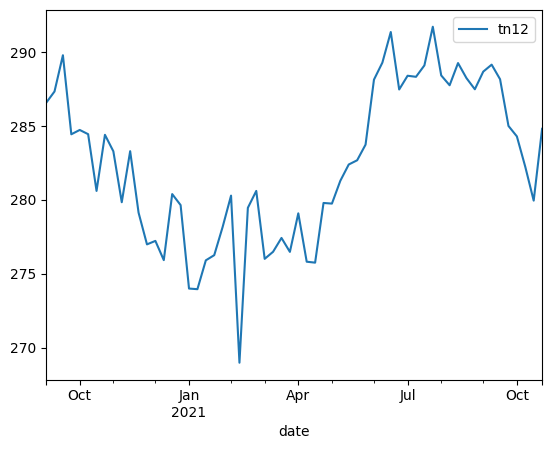

In [46]:
ext_data.groupby(
    pd.Grouper(freq="1W", key="date")
)[["tn12"]].mean().plot()

In [47]:
print(min(ext_data["date"]), max(ext_data["date"]))

print(min(data["date"]), max(data["date"]))

print(min(test_data["date"]), max(test_data["date"]))

2020-09-01 00:00:00 2021-10-21 12:00:00
2020-09-01 01:00:00 2021-09-09 23:00:00
2021-09-10 01:00:00 2021-10-18 21:00:00


In [48]:
data["log_bike_count"]

48321     0.000000
48324     0.693147
48327     0.000000
48330     1.609438
48333     2.302585
            ...   
929175    6.100319
929178    4.983607
929181    5.389072
929184    3.091042
929187    2.772589
Name: log_bike_count, Length: 496827, dtype: float64

<Axes: xlabel='date'>

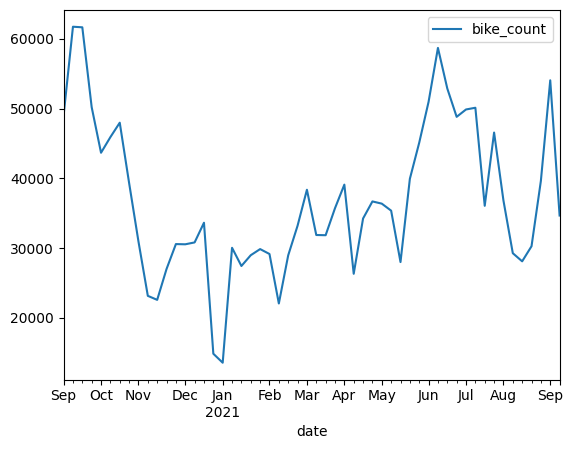

In [49]:
mask = (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")

data[mask].groupby(
    pd.Grouper(freq="1W", key="date")
)[["bike_count"]].sum().plot()

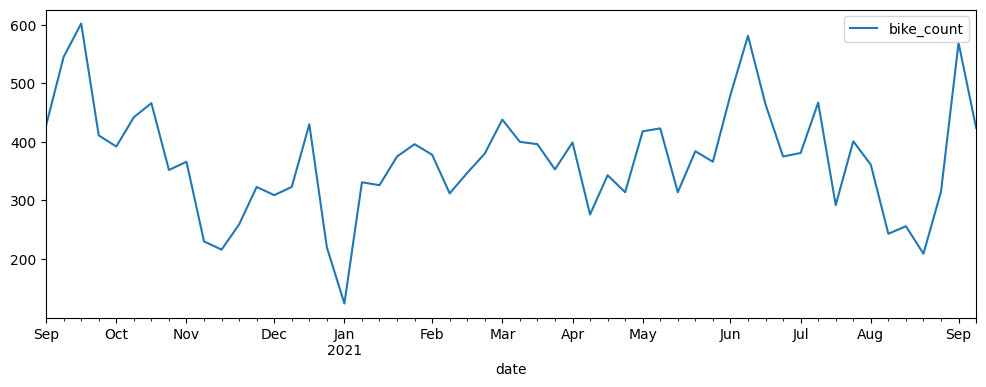

In [50]:
import time

fig, ax = plt.subplots(figsize=(12, 4))
for counter in data["counter_name"].unique():
    mask = (data["counter_name"] == counter)

    data[mask].groupby(
        pd.Grouper(freq="1W", key="date")
    )[["bike_count"]].sum().plot(ax=ax)
    plt.show()

<Axes: xlabel='date'>

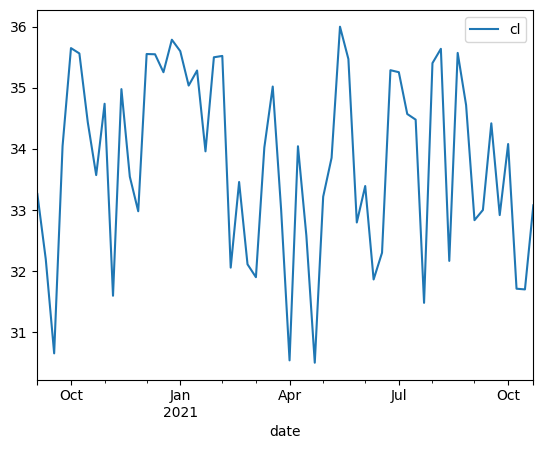

In [51]:
ext_data.groupby(
    pd.Grouper(freq="1W", key="date")
)[["cl"]].mean().plot()

In [52]:
ext_data["numer_sta"].unique()

array([7149])

**General Information**

- numer_sta: Station number (unique identifier for the weather station).
- date: Date of observation (likely in a string format).

**Atmospheric Pressure**
  
- pmer: Atmospheric pressure at sea level (measured in hPa).
- pres: Atmospheric pressure at the station's altitude (measured in hPa).
- niv_bar: Barometric level (could be unused, as it contains all null values).

**Atmospheric Tendencies**

- tend: Atmospheric pressure tendency over a certain period.
- cod_tend: Coded tendency type (indicating patterns like rising, falling, or steady).

**Wind Conditions**

- dd: Wind direction (degrees or coded values).
- ff: Wind speed (likely in m/s or km/h).
- raf10: Maximum wind gust in the last 10 minutes.
- rafper: Period of gust measurement.

**Temperature and Humidity**

- t: Temperature (°C).
- td: Dew point temperature (°C).
- u: Relative humidity (%).

**Visibility and Weather**

- vv: Horizontal visibility (likely in meters or km).
- ww: Weather phenomenon code (e.g., rain, snow, clear skies).
- w1, w2: Additional weather codes (possibly secondary phenomena).

**Cloud Coverage**

- n: Total cloud cover (measured in octas or another scale).
- nbas: Cloud cover at the base level.
- hbas: Height of the cloud base (in meters).
- cl, cm, ch: Cloud types (low, medium, high-level clouds).

**Rainfall and Precipitation**

- rr1, rr3, rr6, rr12, rr24: Precipitation (rainfall) over 1, 3, 6, 12, and 24 hours (likely in mm).

**Snow and Ground State**

- etat_sol: Ground state (e.g., dry, wet, frozen).
- ht_neige: Snow height on the ground (in cm).
- ssfrai, perssfrai: Fresh snow thickness and persistence.

**Specific Phenomena**

- phenspe1 to phenspe4: Codes for specific weather phenomena (e.g., thunderstorm, fog).

**Cloud Layers**

- nnuage1 to nnuage4: Cloud cover for individual layers (in octas).
- ctype1 to ctype4: Cloud types for each layer.
- hnuage1 to hnuage4: Height of the cloud layers (in meters).

**Temperature Extremes**

- tn12, tn24: Minimum temperature over 12 and 24 hours (°C).
- tx12, tx24: Maximum temperature over 12 and 24 hours (°C).
- tminsol: Minimum temperature at the ground surface (°C).

**Radiation and Energy**

- sw, tw: Solar or thermal radiation (values are null in your dataset, possibly unused).

**Geopotential Height**

- geop: Geopotential height (measured at a specific pressure level, null in this dataset).


In [53]:
for counter in data["counter_name"].unique():
    print(data[data["counter_name"] == counter]["date"].nunique())

8974
8974
8974
8974
8974
8974
8519
8519
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8968
8968
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8974
8973
8974
8974
8974
8974
8974
8974
8974
6577
6577


<Axes: xlabel='date'>

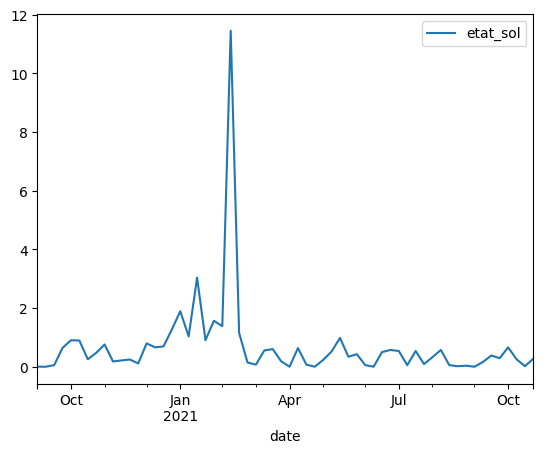

In [54]:
ext_data.groupby(
    pd.Grouper(freq="1W", key="date")
)[["etat_sol"]].mean().plot()

In [56]:
ext_to_merge = ext_data[["date", "rr12", "ff", "etat_sol", "t"]]

In [58]:
ext_to_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      3322 non-null   datetime64[ns]
 1   rr12      3300 non-null   float64       
 2   ff        3322 non-null   float64       
 3   etat_sol  3270 non-null   float64       
 4   t         3322 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 129.9 KB


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

In [71]:
def _merge_external_data(X):
    df_ext = pd.read_csv("external_data/external_data.csv", parse_dates=["date"])
    df_ext["date"] = df_ext["date"].astype('datetime64[us]')
    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])
    X = pd.merge_asof(
        X.sort_values("date"), df_ext[["date", "t", "rr6", "ff"]].sort_values("date"), on="date"
    )
    # Sort back to the original order
    X = X.sort_values("orig_index")
    del X["orig_index"]
    return X

In [77]:
data_aug = _merge_external_data(data)
data_aug.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count,t,rr6,ff
107,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,285.75,0.0,1.6
153,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147,283.95,0.0,1.1
201,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,283.95,0.0,1.1
782,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438,293.65,0.0,4.0
925,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585,292.15,0.0,3.0


In [79]:
target_column_name

NameError: name 'target_column_name' is not defined

In [ ]:
def get_train_data(X):
    # Sort by date first, so that time based cross-validation would produce correct results
    X = X.sort_values(["date", "counter_name"])
    y_array = X[_target_column_name].values
    X_df = data.drop([_target_column_name, "bike_count"], axis=1)
    return X_df, y_array

In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


In [74]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]
numerical_cols = ["t", "rr6", "ff"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("num", StandardScaler(), numerical_cols)
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

In [75]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

Train set, RMSE=0.80
Valid set, RMSE=0.73


C:\Users\willi\OneDrive\Bureau\X-HEC\Python projects\Kaggle_challenge\bike_counters\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\willi\OneDrive\Bureau\X-HEC\Python projects\Kaggle_challenge\bike_counters\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")